<a href="https://colab.research.google.com/github/ramanath-naik/machine_learning/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import numpy as np
import pandas as pd
#for pytorch
import torch
import torch.nn as nn

# device = torch.device("cuda")

#for BERT
import transformers
from transformers import AutoModel, BertTokenizerFast
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
# optimizer from hugging face transformers
from transformers import AdamW

In [7]:

df = pd.read_csv('/content/sample_data/Sentiment_Analysis.csv')

In [8]:
df.head()

,sentence,label
0,Ok brokeback mountain is such a horrible movie.,0
1,Brokeback Mountain was so awesome.,1
2,friday hung out with kelsie and we went and sa...,0
3,I am going to start reading the Harry Potter s...,1
4,"Is it just me, or does Harry Potter suck?...",0


In [9]:
df.describe()

,label
count,5668.000000
mean,0.565279
std,0.495764
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [10]:
#calculates the number of words (tokens) in each sentence in the DataFrame column df['sentence'] and stores these lengths in a list lens
#len(i.split()): For each sentence i, split() divides the sentence into words based on whitespace (by default).
#len(...) calculates the number of words (tokens) in the split sentence.
lens=[len(i.split()) for i in df.sentence]


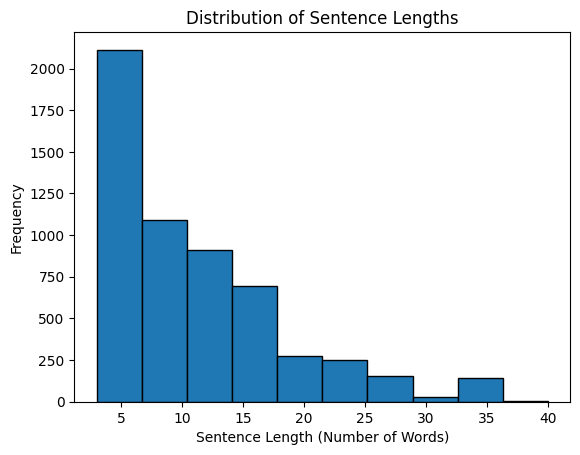

(array([2113., 1092.,  912.,  692.,  276.,  253.,  155.,   29.,  142.,
           4.]),
 array([ 3. ,  6.7, 10.4, 14.1, 17.8, 21.5, 25.2, 28.9, 32.6, 36.3, 40. ]),
 <BarContainer object of 10 artists>)

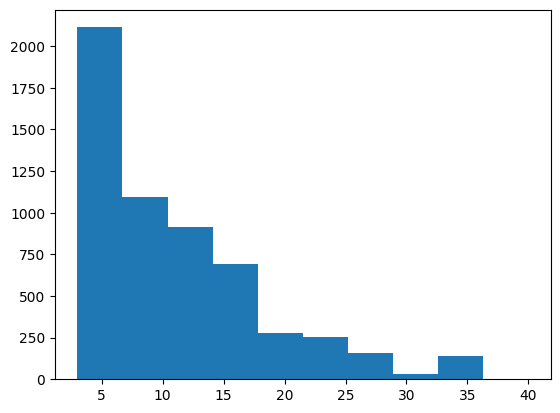

In [14]:
import matplotlib.pyplot as plt
plt.hist(lens, bins=10, edgecolor='black')
plt.xlabel('Sentence Length (Number of Words)')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Lengths')
plt.show()
plt.hist(lens)

In [16]:
#Installing Transformers
!pip install transformers

In [17]:
# split into train, validation and test sets in the ration 70 : 15 : 15
train_text, temp_text, train_labels, temp_labels = train_test_split(df['sentence'], df['label'],
                                                                    random_state=2021,
                                                                    test_size=0.3,
                                                                    stratify=df['label'])

val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2021,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

In [18]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [19]:
# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

(array([1504.,  701.,  572.,  521.,  164.,  215.,  117.,   63.,  104.,
           6.]),
 array([ 3. ,  6.5, 10. , 13.5, 17. , 20.5, 24. , 27.5, 31. , 34.5, 38. ]),
 <BarContainer object of 10 artists>)

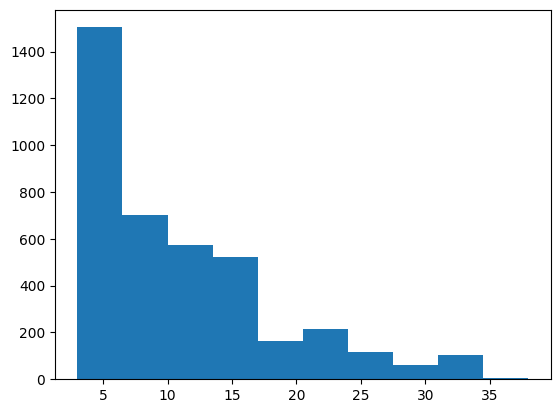

In [20]:
train_lens=[len(i.split()) for i in train_text]
plt.hist(train_lens)

In [23]:
#In NLP tasks, sequences (sentences or text passages) often vary in length. However, models like BERT require fixed-length input sequences.
#pad_len=17 indicates specific length of 17 tokens (words or subwords) for padding sequences.
#Sequences longer than pad_len may be truncated to fit the specified length, depending on the padding/truncation strategy used
pad_len=17

In [24]:
# tokenize and encode sequences
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = pad_len,
    pad_to_max_length=True,
    truncation=True
)

tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = pad_len,
    pad_to_max_length=True,
    truncation=True
)

tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = pad_len,
    pad_to_max_length=True,
    truncation=True
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [26]:
#torch.tensor() converts Python lists (or similar data structures) into PyTorch tensors, which are multi-dimensional arrays similar to NumPy arrays but optimized for GPU computation.
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [28]:
train_mask

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]])

In [33]:
#Defining Some Parameter
#In the context of programming and deep learning frameworks like PyTorch, a tensor is a multi-dimensional array.
#Tensors are fundamental data structures used to store and manipulate data efficiently, especially in the context of neural networks.


#define a batch size.Batch size refers to the number of training examples utilized in one iteration of training.
# batch_size = 64
batch_size = 32

# wrap tensors
#It's used to create a dataset that combines input data (features) and their corresponding labels (targets) into a single dataset object.
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)


# freeze the BERT architecture

for param in bert.parameters():
    param.requires_grad = False

In [30]:
class BERT_architecture(nn.Module):

    #Initializes the neural network architecture
    def __init__(self, bert):

      super(BERT_architecture, self).__init__()

      #This allows the class to integrate and utilize pre-trained BERT embeddings.
      self.bert = bert

      # dropout layer
      self.dropout = nn.Dropout(0.2)

      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)

      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)

      # apply softmax activation
      x = self.softmax(x)

      return x

In [34]:
# pass the pre-trained BERT to our define architecture
model = BERT_architecture(bert)

# # push the model to GPU
# model = model.to(device)

In [32]:
import torch

# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(torch.cuda.get_device_name(0))  # Print GPU name
else:
    device = torch.device("cpu")
    print("CUDA is not available. Training on CPU.")


CUDA is not available. Training on CPU.


In [35]:
# define the optimizer
optimizer = AdamW(model.parameters(),lr = 1e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [36]:
from sklearn.utils.class_weight import compute_class_weight
#compute the class weights
class_weights = compute_class_weight(class_weight = "balanced",
                                        classes = np.unique(train_labels),
                                        y = train_labels
                                     )
print("class weights are {} for {}".format(class_weights,np.unique(train_labels)))


class weights are [1.14985507 0.88470116] for [0 1]


During training, the loss function will give more importance to errors made on the minority class (class 0) due to its higher weight. This helps in balancing the learning process and prevents the model from becoming biased towards the majority class (class 1).

In [37]:
pd.value_counts(train_labels)

label
1    2242
0    1725
Name: count, dtype: int64

In [43]:
#wrap class weights in tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push weights to GPU
# weights = weights.to(device)

# define loss function
# add weights to handle the "imbalance" in the dataset
cross_entropy  = nn.NLLLoss(weight=weights)

# number of training epochs
# epochs = 100
epochs = 50

In [40]:
# function to train the model
def train():

  model.train()

  total_loss, total_accuracy = 0, 0

  # empty list to save model predictions
  total_preds=[]

  # iterate over batches
  for step,batch in enumerate(train_dataloader):

    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]

    sent_id, mask, labels = batch

    # clear previously calculated gradients
    model.zero_grad()

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)

  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [41]:
# function for evaluating the model
def evaluate():

  print("\nEvaluating...")

  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0

  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):

    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:

      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():

      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader)

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

Training of BERT Model

In [44]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, _ = train()

    #evaluate model
    valid_loss, _ = evaluate()

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print('\nTraining Loss: {}'.format(train_loss))
    print('Validation Loss: {}'.format(valid_loss))


 Epoch 1 / 50
  Batch    50  of    124.
  Batch   100  of    124.

Evaluating...

Training Loss: 0.6885864768297442
Validation Loss: 0.6816417950171011

 Epoch 2 / 50
  Batch    50  of    124.
  Batch   100  of    124.

Evaluating...

Training Loss: 0.6840141333879963
Validation Loss: 0.6718490675643638

 Epoch 3 / 50
  Batch    50  of    124.
  Batch   100  of    124.

Evaluating...

Training Loss: 0.6777211442109077
Validation Loss: 0.6664364602830675

 Epoch 4 / 50
  Batch    50  of    124.
  Batch   100  of    124.

Evaluating...

Training Loss: 0.6722791651564259
Validation Loss: 0.6592307775108902

 Epoch 5 / 50
  Batch    50  of    124.
  Batch   100  of    124.

Evaluating...

Training Loss: 0.6650017903697106
Validation Loss: 0.6538502286981653

 Epoch 6 / 50
  Batch    50  of    124.
  Batch   100  of    124.

Evaluating...

Training Loss: 0.6594983401798433
Validation Loss: 0.6465370655059814

 Epoch 7 / 50
  Batch    50  of    124.
  Batch   100  of    124.

Evaluating...


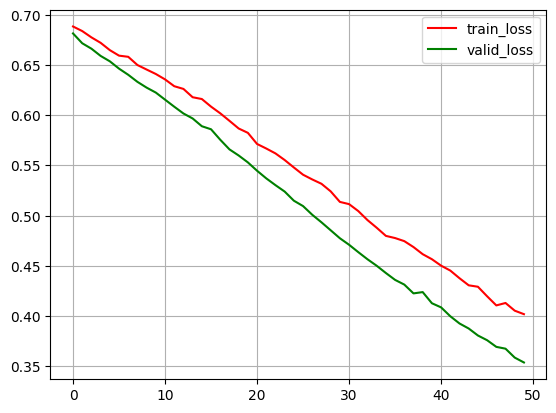

In [45]:
from matplotlib import pyplot as plt
plt.plot(train_losses,color = 'red',label = 'train_loss')
plt.plot(valid_losses,color = 'green',label = 'valid_loss')
plt.grid()
plt.legend()
plt.show()

In [46]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [47]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [48]:
from sklearn.metrics import classification_report,accuracy_score

In [49]:
pred = np.argmax(preds, axis = 1)
# Calculate classification report and accuracy
report = classification_report(test_y, pred, output_dict=True)
accuracy = accuracy_score(test_y, pred)

# Print classification report
print("Classification Report:")
print(classification_report(test_y, pred))

# Print accuracy
print("Accuracy:", accuracy)

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       370
           1       0.91      0.94      0.93       481

    accuracy                           0.91       851
   macro avg       0.91      0.91      0.91       851
weighted avg       0.91      0.91      0.91       851

Accuracy: 0.9142185663924794


In [50]:
# Create a DataFrame to store metrics
metrics_df = pd.DataFrame(report).transpose()

# Add accuracy to the DataFrame
metrics_df.loc['accuracy'] = accuracy

# Display the DataFrame
print("\nMetrics DataFrame:")
metrics_df


Metrics DataFrame:


,precision,recall,f1-score,support
0,0.915966,0.883784,0.899587,370.000000
1,0.912955,0.937630,0.925128,481.000000
accuracy,0.914219,0.914219,0.914219,0.914219
macro avg,0.914461,0.910707,0.912358,851.000000
weighted avg,0.914265,0.914219,0.914023,851.000000


In [51]:
def convert_predictions(binary_predictions):
    return np.where(binary_predictions == 0, "negative", "True")
pred_mapped = convert_predictions(pred)
pred_mapped[:50]

array(['negative', 'negative', 'True', 'True', 'negative', 'negative',
       'True', 'True', 'True', 'negative', 'negative', 'negative', 'True',
       'negative', 'negative', 'True', 'negative', 'True', 'negative',
       'True', 'True', 'negative', 'negative', 'negative', 'True',
       'negative', 'True', 'True', 'negative', 'True', 'negative',
       'negative', 'negative', 'negative', 'negative', 'negative',
       'negative', 'negative', 'True', 'True', 'True', 'True', 'True',
       'True', 'True', 'negative', 'negative', 'True', 'True', 'True'],
      dtype='<U8')